In [117]:
import os
import yaml
import importlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [118]:
### Parameters of the training ###

split = "even" 
#split = "odd" 
# split = even | odd -> on what split to train the model (will be in the name)
# -> you need one "odd" and one "even" models to be put inside bamboo

suffix = 'test'
# Suffix that will be added to the saved model (so multiple DNNs can be trained)

quantile = 0.95 # We will repeat the part of the weights rightmost tail
# Eg : 0.95, means we take the 5% events on the right tail of training weight and repeat them
# 1.0 means no correction (to be used if you want to diable it)

# DNN hyperparameters #
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 256,
    'n_layers'              : 3,
    'n_neurons'             : 64,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
    'l2'                    : 1e-6,
    'dropout'               : 0.,
    'batch_norm'            : True,
}
# L2 is an additional term in the loss function : l2 x ||W||**2 where ||W|| is the sum of all the DNN weights 
#    inside the neurons
# -> when overfitting the weights take large values, this tells the optimizer the trade off between performances
#    and generalization (from experience, a small value always helps)
# Dropout is a frequency of killing neurons at each batch (no backprogation for them)
# -> used generally when overfitting is detected, to avoid that the DNN learns too much 
#    (from experience, not always useful, put it when you see overfitting)
# Batch normalization is a layer that normalizes the output of each neuron (see documentation)
# -> usually helps that the gradient does not go too far and backprogation is always smooth (supposedly)
#    (from experience : always used it, maybe not worth all the time)


# Input variables
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E",
            "Muon_pT",
            "Muon_Eta",
            "Muon_Phi",
            "nJets",
            "E_jet1",
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [119]:
# Load the required data #
outputPath = '/home/ucl/cp3/sdonerta/bamboodev/WWGG/ttGJets_Skim_11_01/'
skimFile = os.path.join(outputPath,'results','Skim.parquet')
yamlFile = os.path.join(outputPath,'plots.yml')

# Load dataframe from parquet #
df = pd.read_parquet(skimFile)

# Load samples + plots data from yaml file #
with open(yamlFile,'r') as handle:
    config = yaml.full_load(handle)


In [120]:
# Cut negative event weights #
df = df[(df['weight']>0) & (df['weight']<300)]
#df = df[df['weight']>0]

# Cut QCD events #
df = df[~df.process.str.contains("QCD")]
df = df[~df.process.str.contains("TTGamma_")]


In [121]:
# Set labels #
df["label"] = 0
for process in pd.unique(df['process']):
    if process not in config['files']:
        raise RuntimeError(f'Process {process} not found in yaml config file')
    if config['files'][process]['type'] == 'signal':
        df.loc[df['process']==process, ['label']] = 1

In [122]:
print(df)

         weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2  \
0      0.000025  1.151401  2.699523   1.979170    1.137842  1.603054   
1      0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574   
2      0.000025  0.276418  0.034514   0.957748    0.922289  1.291733   
3      0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431   
4      0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589   
..          ...       ...       ...        ...         ...       ...   
292  222.838821  0.537853 -0.913064   0.504694    0.439566 -1.815641   
293  222.838821 -0.251346  1.956208   0.473330    0.458763  2.421668   
294  222.838821  2.512119 -2.288071   2.253552    0.363121  0.382940   
295  222.838821  1.106448 -0.011611   0.635271    0.378777 -1.377905   
296  222.838821  1.584808 -0.537055   0.922351    0.362892 -1.123914   

      Phi_ph2  E_mGG_ph2  pT_mGG_ph2  Electron_E  ...  Phi_jet1      E_jet2  \
0    1.725826   2.097534    0.811509  233.906647  ... -2

In [123]:
# Produce physical event weight #
df['event_weight'] = pd.Series(np.zeros(df.shape[0]))
lumi = config['configuration']['luminosity']['HL-LHC']
for process in pd.unique(df['process']):
    print (f'Looking at process {process}')
    if 'cross-section' in config['files'][process].keys() and config['files'][process]['type'] != 'signal':
        cross_section = config["files"][process]["cross-section"]
    else:
        cross_section = 1.
        # For signal, we assume unit cross section (otherwise significance can be too unstable)
    if 'branching-ratio' in config['files'][process].keys():
        BR = config["files"][process]["branching-ratio"]
    else:
        BR = 1
    if 'generated-events' in config['files'][process].keys():
        
        generated_events = config["files"][process]["generated-events"]
    else:
        raise RuntimeError('Process {process} is missing `generated-events` entry, should not happen')
        
    print (f'... cross-section = {cross_section}')
    print (f'... branching-ratio = {BR}')
    print (f'... generated-events = {generated_events}')
    factor = lumi * cross_section * BR / generated_events
    # We don't really care about luminosity because the scale of the weights do not matter, and you have a single lumi
    print (f'   -> Total factor = {factor}')
    # Apply to the new event_weight columns #
    df.loc[df["process"]==process,'event_weight'] = df[df["process"]==process]['weight'] * factor
    print (f'   Sum of weights = {df[df["process"]==process]["weight"].sum()} -> {df[df["process"]==process]["event_weight"].sum()}')


if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

Looking at process GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
... cross-section = 1.0
... branching-ratio = 1
... generated-events = 65241.65374448523
   -> Total factor = 45.982893256343694
   Sum of weights = 2.3057548999786377 -> 106.02531138348118
Looking at process GluGluToHHTo2G2l2nu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
... cross-section = 1.0
... branching-ratio = 1
... generated-events = 62981.895101338625
   -> Total factor = 47.632736283545675
   Sum of weights = 0.9934101700782776 -> 47.31884992925153
Looking at process GluGluToHHTo2G2Tau_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
... cross-section = 1.0
... branching-ratio = 1
... generated-events = 64462.776279225945
   -> Total factor = 46.53848582327958
   Sum of weights = 0.09635860472917557 -> 4.4843837260278985
Looking at process TTGJets_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
... cross-section = 4.577
... branching-ratio = 1
... generated-events = 747768

In [124]:
# Compute training weight #
if 'training_weight' in df.columns:
    del df['training_weight']
df['training_weight'] = df['event_weight'].copy()

df.loc[df['label']==1,'training_weight'] *= df.shape[0]/2 / (df[df['label']==1]['event_weight']).sum()
df.loc[df['label']==0,'training_weight'] *= df.shape[0]/2 / (df[df['label']==0]['event_weight']).sum()
 

In [125]:
import utils
importlib.reload(utils) # Reload in case file has changed
print ('Using event weight')
utils.checkBatches(df,weight_column='event_weight',batch_size=parameters['batch_size'])
print ('Using training weight')
utils.checkBatches(df,weight_column='training_weight',batch_size=parameters['batch_size'])

Using event weight
On average, per batch the total learning weight is
	... signal     :     0.076728751 [146.99 events]
	... background : 12942.609469360 [109.01 events]
Using training weight
On average, per batch the total learning weight is
	... signal     :   128.954349870 [147.25 events]
	... background :   129.994871217 [108.75 events]


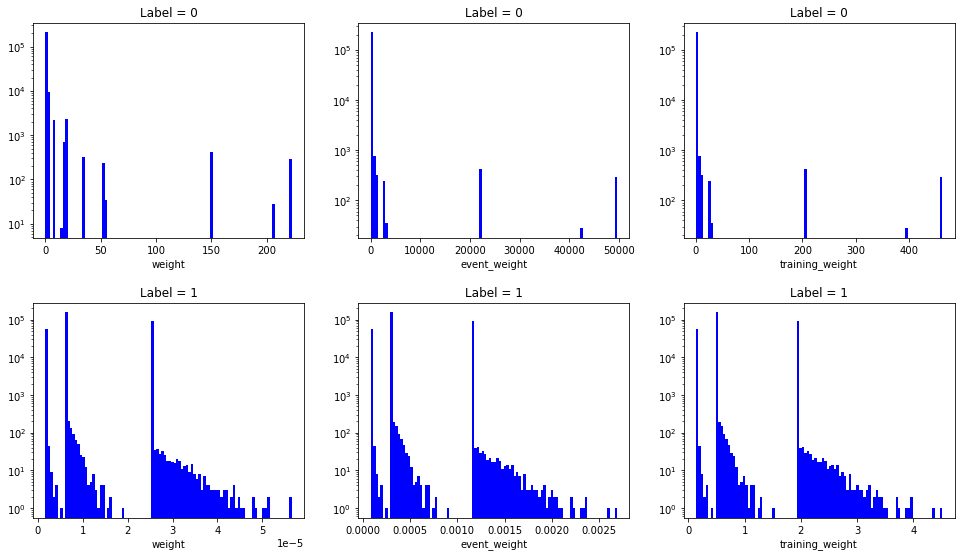

In [126]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=2,ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)
for irow,label in enumerate([0,1]):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['label']==label][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Label = {label}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
fig.savefig("event_weights_A.pdf", dpi = 300)


In [127]:
# Plot the weights per process #
if False:
    with PdfPages("event_weights_B.pdf") as pdf:
        for process in pd.unique(df['process']):
            fig,axs = plt.subplots(figsize=(16,6),nrows=1,ncols=3)
            fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2,hspace=0.3)
            fig.suptitle(f"Process {process}")
            for icol,column in enumerate(['weight','event_weight','training_weight']):
                axs[icol].hist(df[df['process']==process][column],bins=100,color='b')
                axs[icol].set_xlabel(column)
                axs[icol].set_xlim(0,(df[df['process']==process][column]).max()*1.5)
                axs[icol].set_yscale('log')
            pdf.savefig()
            plt.close(fig)

In [128]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   2.097534   
1   -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   2.815203   
2    0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   0.430226   
3    1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   6.344330   
4   -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   0.565238   
..        ...       ...        ...         ...       ...       ...        ...   
292  0.537853 -0.913064   0.504694    0.439566 -1.815641 -2.161134   0.718718   
293 -0.251346  1.956208   0.473330    0.458763  2.421668  1.493729   0.969539   
294  2.512119 -2.288071   2.253552    0.363121  0.382940  2.761229   0.376099   
295  1.106448 -0.011611   0.635271    0.378777 -1.377905 -1.689551   0.453097   
296  1.584808 -0.537055   0.922351    0.362892 -1.123914 -2.342903   0.301572   

     pT_mGG_ph2  Electron_E

In [129]:
# Determine splitting variable #
split_var = df['Phi_ph1'].copy()
split_var = np.abs(split_var)
split_var *= 1e4
split_var -= np.floor(split_var) 
split_var = (split_var*1e1).astype(int)
split_var = split_var %2 == 0
print (f'Even set has {df[split_var].shape[0]:10d} events [{df[split_var].shape[0]/df.shape[0]*100:5.2f}%]')
print (f'Odd  set has {df[~split_var].shape[0]:10d} events [{df[~split_var].shape[0]/df.shape[0]*100:5.2f}%]')

Even set has     264690 events [50.00%]
Odd  set has     264704 events [50.00%]


In [130]:
# Sets splitting #
print (f'Using split type {split}')
# split_var = True (even number) | False (odd number)
# Name of the model is related to the even | odd quality of the events during inference (ie, in bamboo)
if split == 'even':
    train_df = df[~split_var] # Trained on odd
    test_df  = df[split_var]  # Evaluated on even 
elif split == 'odd':
    train_df = df[split_var]  # Trained on even
    test_df  = df[~split_var] # Evaluated on odd 
else:
    raise RuntimeError(f'Split needs to be either odd or even, is {split}')

# Randomize for training (always good to randomize) #
train_df = train_df.sample(frac=1)

# Quantile corrections #
# When an event has a large weight, it can imbalance a lot the training, still the weight might have a meaning
# Idea : instead of 1 event with wi>>1, we use N copies of the event with wf = wi/N
# From the point of view of the physics it does not matter, the total event weight sum of each process is the same
# From the point of view of the DNN, we have split a tough nut to crack into several smaller ones

quantile_lim = train_df['training_weight'].quantile(quantile)
print (f'{(1-quantile)*100:5.2f}% right quantile is when weight is at {quantile_lim}')
print ('  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability') 

# Select the events #
idx_to_repeat = train_df['training_weight'] >= quantile_lim                          
events_excess = train_df[idx_to_repeat].copy()

saved_columns = train_df[['training_weight','process']].copy()

# Compute multiplicative factor #
factor = (events_excess['training_weight']/quantile_lim).values.astype(np.int32) 

# Correct the weights of events already in df #
train_df.loc[idx_to_repeat,'training_weight'] /= factor

# Add N-1 copies #
arr_to_repeat = train_df[idx_to_repeat].values                                       
repetition = np.repeat(np.arange(arr_to_repeat.shape[0]), factor-1)                   
df_repeated = pd.DataFrame(np.take(arr_to_repeat,repetition,axis=0),columns=train_df.columns)
df_repeated = df_repeated.astype(train_df.dtypes.to_dict()) # otherwise dtypes are object
train_df = pd.concat((train_df,df_repeated),axis=0,ignore_index=True).sample(frac=1).reset_index() # Add and randomize

# Printout #
print ('Changes per process in training set')
for process in pd.unique(train_df['process']):
    N_before = saved_columns[saved_columns['process']==process].shape[0]
    N_after  = train_df[train_df['process']==process].shape[0]
    if N_before != N_after:
        print (f"{process:20s}")
        print (f"... {N_before:6d} events [sum weight = {saved_columns[saved_columns['process']==process]['training_weight'].sum():14.6f}]",end=' -> ')
        print (f"{N_after:6d} events [sum weight = {train_df[train_df['process']==process]['training_weight'].sum():14.6f}]")
    
print ()
print (f"Total entries : {saved_columns.shape[0]:14d} -> {train_df.shape[0]:14d}")
print (f"Total event sum : {saved_columns['training_weight'].sum():14.6f} -> {train_df['training_weight'].sum():14.6f}")

# Validation split #
train_df,val_df  = train_test_split(train_df,test_size=0.3)

# Printout #
print ('\nFinal sets')
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Using split type even
 5.00% right quantile is when weight is at 1.9649697181217025
  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability
Changes per process in training set
DYJets_incl_MLL-50_TuneCUETP8M1_14TeV-madgraphMLM-pythia8_200PU.root
...    156 events [sum weight =   72131.247334] ->  36660 events [sum weight =   72131.247334]
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
...    206 events [sum weight =   42849.189974] ->  21630 events [sum weight =   42849.189974]
GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
...  45174 events [sum weight =   88861.770627] ->  45175 events [sum weight =   88861.770627]
TT_TuneCUETP8M2T4_14TeV-powheg-pythia8_200PU.root
...    131 events [sum weight =    3364.161603] ->   1703 events [sum weight =    3364.161603]
W2JetsToLNu_TuneCUETP8M1_14TeV-madgraphMLM-pythia8_200PU.root
...     15 events [sum weight =    5929.240104] ->   3015 eve

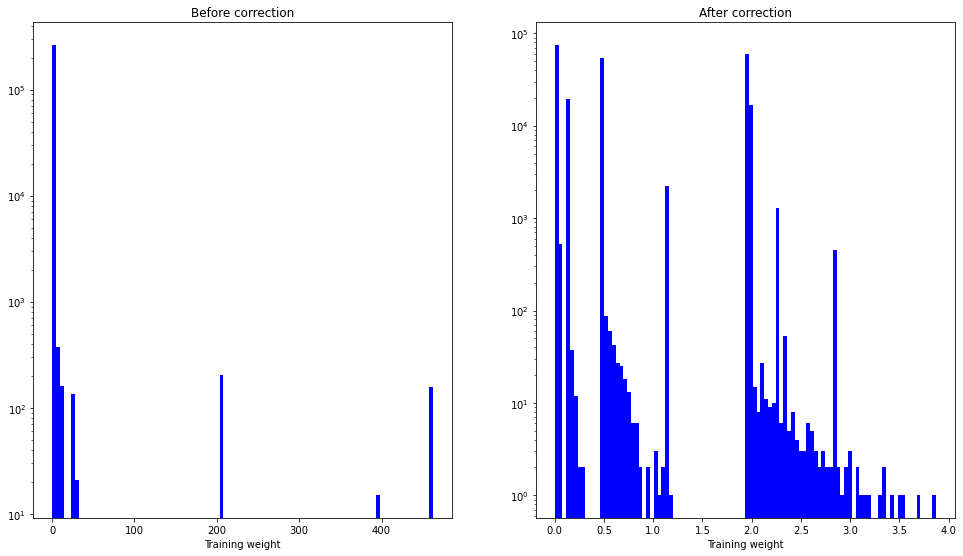

In [131]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)

if split == 'even':
    axs[0].hist(df[~split_var]['training_weight'],bins=100,color='b')
elif split == 'odd':
    axs[0].hist(df[split_var]['training_weight'],bins=100,color='b')
axs[0].set_title("Before correction")
axs[0].set_xlabel("Training weight")
axs[0].set_yscale('log')
axs[1].hist(train_df['training_weight'],bins=100,color='b')
axs[1].set_title("After correction")
axs[1].set_xlabel("Training weight")
axs[1].set_yscale('log')
fig.savefig("event_weights_C.pdf", dpi = 300)

In [132]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")

# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                         variance = train_df[input_vars].var(axis=0),
                                         name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                     activation           = parameters['hidden_activation'], 
                     activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                     name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 1, 
                       activation           = parameters['output_activation'],
                       activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                       name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

In [133]:
model_preprocess = keras.Model(inputs=inputs, outputs=normalizer)
out_test = model_preprocess.predict(train_df[input_vars],batch_size=5000)
print ('Input (after normalization) mean (should be close to 0)')
print (out_test.mean(axis=0))
print ('Input (after normalization) variance (should be close to 1)')
print (out_test.var(axis=0))

Input (after normalization) mean (should be close to 0)
[ 3.6976051e-09 -3.0407413e-08  5.2159539e-08 -5.7458256e-09
  8.0246643e-10  4.4514078e-08  1.2073543e-08 -1.8594619e-09
  3.0909212e-07 -2.5047593e-09 -1.6002478e-07  2.0487776e-07
  4.7400164e-07 -4.1395710e-06  2.6036156e-07  3.0304802e-06
 -1.7353919e-07 -2.1041636e-07  3.0973786e-07 -5.3709419e-07
  1.8703805e-08  5.3406524e-07  1.4128956e-07 -3.1081465e-06
  6.5546413e-07  3.2837207e-07  4.0062204e-07 -7.1216306e-08]
Input (after normalization) variance (should be close to 1)
[0.9999633  0.99994284 0.9999349  0.99994075 0.99994516 0.9999102
 0.9999667  0.999947   0.9998009  1.0000256  0.99988115 0.99990904
 1.0016652  0.9980174  0.9999948  0.99996835 0.99944663 0.9993203
 1.0006269  0.9999031  0.9999802  0.99899584 1.0007247  0.999911
 0.99989843 1.0003821  0.9994954  0.999928  ]


In [134]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
particles (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
Normalization (Normalization (None, 28)                57        
_________________________________________________________________
dense_0 (Dense)              (None, 64)                1856      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160

/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [135]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001, 
                               patience = 20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0.001, 
                                   patience = 8,
                                   min_lr = 1e-8,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [136]:
history = model.fit(
    train_df[input_vars],
    train_df['label'],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df['label'],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/200
899/899 - 9s - loss: 0.1651 - binary_accuracy: 0.6857 - auc_4: 0.7933 - precision_4: 0.6084 - recall_4: 0.8938 - val_loss: 0.1185 - val_binary_accuracy: 0.6919 - val_auc_4: 0.8091 - val_precision_4: 0.6095 - val_recall_4: 0.9288
Epoch 2/200
899/899 - 5s - loss: 0.1054 - binary_accuracy: 0.6930 - auc_4: 0.8160 - precision_4: 0.6077 - recall_4: 0.9438 - val_loss: 0.1027 - val_binary_accuracy: 0.6960 - val_auc_4: 0.8242 - val_precision_4: 0.6090 - val_recall_4: 0.9567
Epoch 3/200
899/899 - 5s - loss: 0.0907 - binary_accuracy: 0.6939 - auc_4: 0.8136 - precision_4: 0.6071 - recall_4: 0.9535 - val_loss: 0.0911 - val_binary_accuracy: 0.6940 - val_auc_4: 0.8091 - val_precision_4: 0.6081 - val_recall_4: 0.9513
Epoch 4/200
899/899 - 5s - loss: 0.0825 - binary_accuracy: 0.6942 - auc_4: 0.8129 - precision_4: 0.6067 - recall_4: 0.9582 - val_loss: 0.0890 - val_binary_accuracy: 0.6839 - val_auc_4: 0.7968 - val_precision_4: 0.5991 - val_recall_4: 0.9566
Epoch 5/200
899/899 - 5s - loss: 0.0

Epoch 35/200
899/899 - 5s - loss: 0.0330 - binary_accuracy: 0.6977 - auc_4: 0.7969 - precision_4: 0.6065 - recall_4: 0.9819 - val_loss: 0.0771 - val_binary_accuracy: 0.6899 - val_auc_4: 0.7913 - val_precision_4: 0.6017 - val_recall_4: 0.9740
Epoch 36/200
899/899 - 5s - loss: 0.0324 - binary_accuracy: 0.6975 - auc_4: 0.7962 - precision_4: 0.6063 - recall_4: 0.9820 - val_loss: 0.0772 - val_binary_accuracy: 0.6900 - val_auc_4: 0.7913 - val_precision_4: 0.6019 - val_recall_4: 0.9737
Epoch 37/200
899/899 - 5s - loss: 0.0326 - binary_accuracy: 0.6975 - auc_4: 0.7963 - precision_4: 0.6063 - recall_4: 0.9821 - val_loss: 0.0771 - val_binary_accuracy: 0.6895 - val_auc_4: 0.7898 - val_precision_4: 0.6013 - val_recall_4: 0.9747

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 38/200
899/899 - 5s - loss: 0.0321 - binary_accuracy: 0.6978 - auc_4: 0.7965 - precision_4: 0.6065 - recall_4: 0.9817 - val_loss: 0.0770 - val_binary_accuracy: 0.6897 - val_auc_4: 0.7903

Curves saved as loss_test_even.png


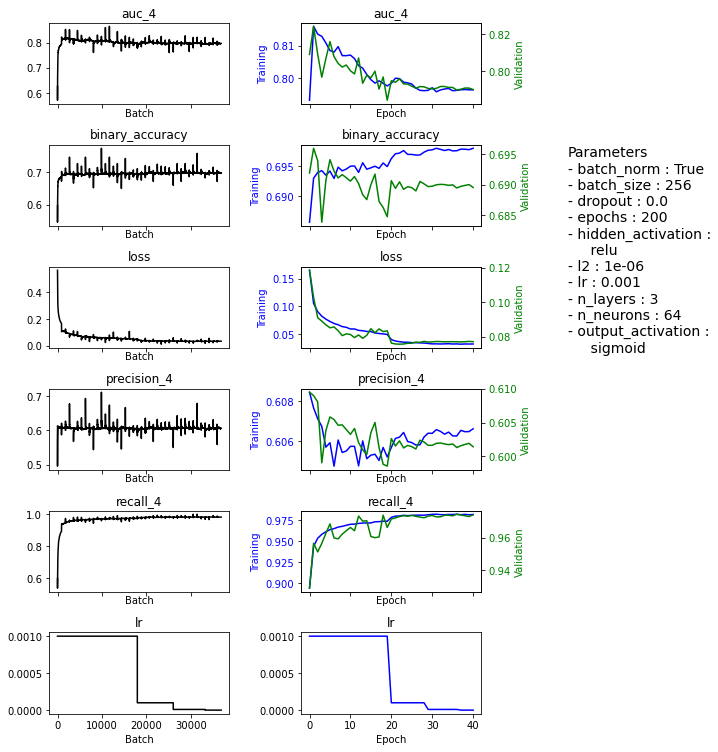

In [137]:
History.PlotHistory(loss_history,params=parameters,outputName=f'loss_{suffix}_{split}.png')
# Params is a dict of parameters with name and values
# used for plotting


In [138]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
if 'output' in test_df.columns:
    # If already output, need to remove to add again
    # avoid issues in case you run this cell multiple times
    del test_df['output']
test_df = pd.concat((test_df,pd.DataFrame(output,columns=['output'],index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

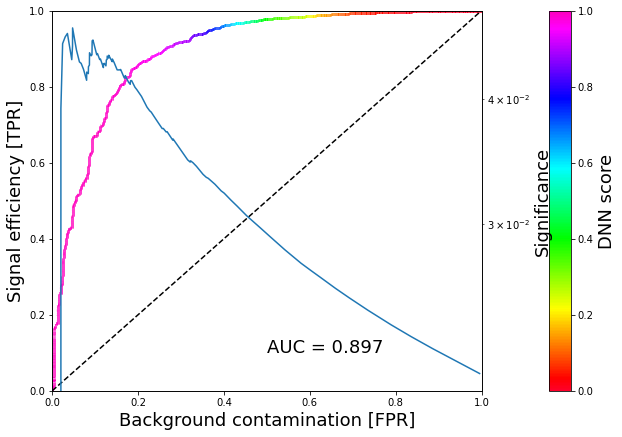

Saved ROC as roc_test_even.pdf
Best WP based on significance = 0.99948


In [139]:
import roc
importlib.reload(roc) # Reload in case file has changed
roc.rocAndSig(y_true     = test_df['label'],
              y_pred     = test_df['output'],
              w_roc      = test_df['training_weight'],
              w_sig      = test_df['event_weight'],
              outputName = f'roc_{suffix}_{split}.pdf')


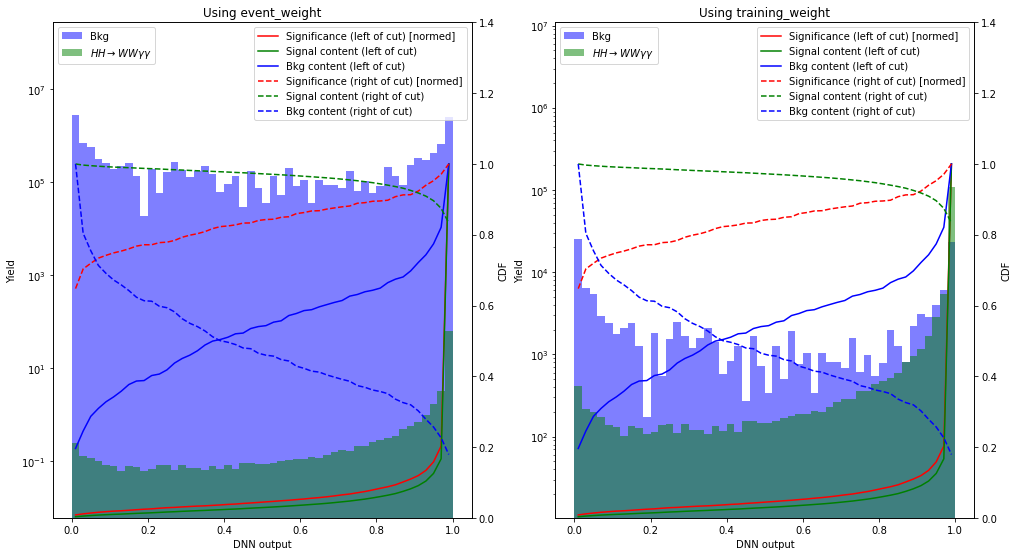

In [140]:
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)

sig_df = test_df[test_df['label']==1]
bkg_df = test_df[test_df['label']==0]

# Manual binning so we can compute significance #
bins = np.linspace(0,1,51)
centers = (bins[1:]+bins[:-1])/2
widths = np.diff(bins)


def get_bin_content(y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for icol,weight in enumerate(['event_weight','training_weight']):
    # Fill the bins myself #
    b = get_bin_content(bkg_df['output'],bkg_df[weight])
    s = get_bin_content(sig_df['output'],sig_df[weight])
    cumsum_s_left = np.cumsum(s)/s.sum()
    cumsum_b_left = np.cumsum(b)/b.sum()
    cumsum_s_right = np.cumsum(s[::-1])[::-1]/s.sum()
    cumsum_b_right = np.cumsum(b[::-1])[::-1]/b.sum()
    # Need to integrate all the bins right of the DNN cut to get significance
    z_left = np.nan_to_num(np.sqrt(2*((cumsum_s_left+cumsum_b_left)*np.log(1+cumsum_s_left/cumsum_b_left)-cumsum_s_left)))
    z_right = np.nan_to_num(np.sqrt(2*((cumsum_s_right+cumsum_b_right)*np.log(1+cumsum_s_right/cumsum_b_right)-cumsum_s_right)))
    z_left /= z_left.max()
    z_right /= z_right.max()
    axs[icol].bar(x=centers,height=b,width=widths,alpha=0.5,color='b',label='Bkg')
    axs[icol].bar(x=centers,height=s,width=widths,alpha=0.5,color='g',label=r'$HH \rightarrow WW \gamma \gamma$')
    ax2=axs[icol].twinx()   
    ax2.plot(centers,z_left,color='r',label='Significance (left of cut) [normed]')
    ax2.plot(centers,cumsum_s_left,color='g',label='Signal content (left of cut)')
    ax2.plot(centers,cumsum_b_left,color='b',label='Bkg content (left of cut)')
    ax2.plot(centers,z_right,color='r',linestyle='--',label='Significance (right of cut) [normed]')
    ax2.plot(centers,cumsum_s_right,color='g',linestyle='--',label='Signal content (right of cut)')
    ax2.plot(centers,cumsum_b_right,color='b',linestyle='--',label='Bkg content (right of cut)')
    #ax2.set_yscale("log")
    #ax2.set_ylim([0,z.max()*1.1])
    ax2.set_ylim([0,1.4])
    ax2.set_ylabel('CDF')
    ax2.legend(loc='upper right')

    axs[icol].set_title(f"Using {weight}")
    axs[icol].set_xlabel('DNN output')
    axs[icol].set_ylabel('Yield')
    axs[icol].set_ylim([s.min()*0.1,np.maximum(s,b).max()*100])
    axs[icol].set_yscale('log')
    axs[icol].legend(loc='upper left')
fig.savefig(f"prediction_{suffix}_{split}.pdf", dpi = 300)



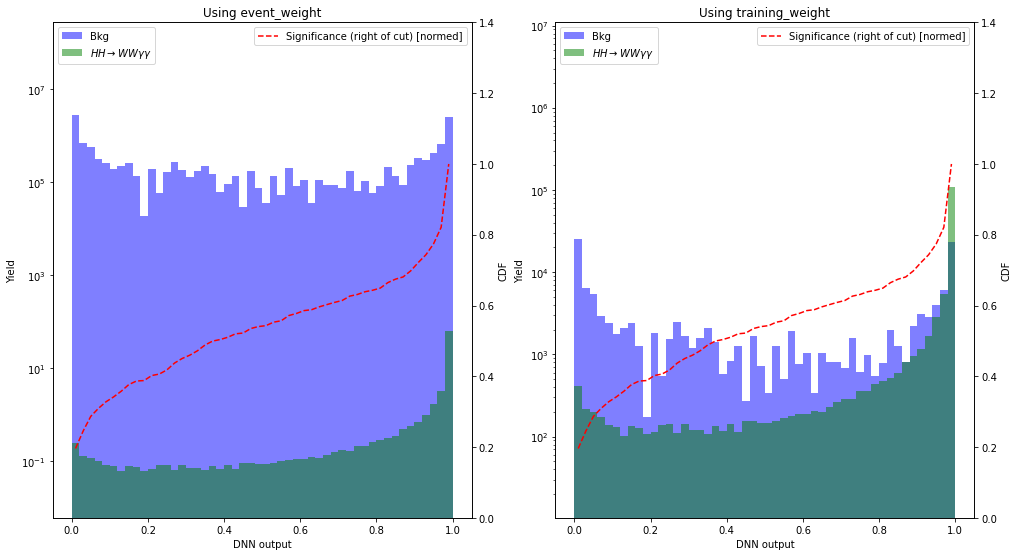

In [141]:
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)

sig_df = test_df[test_df['label']==1]
bkg_df = test_df[test_df['label']==0]

# Manual binning so we can compute significance #
bins = np.linspace(0,1,51)
centers = (bins[1:]+bins[:-1])/2
widths = np.diff(bins)


def get_bin_content(y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for icol,weight in enumerate(['event_weight','training_weight']):
    # Fill the bins myself #
    b = get_bin_content(bkg_df['output'],bkg_df[weight])
    s = get_bin_content(sig_df['output'],sig_df[weight])
    cumsum_s_left = np.cumsum(s)/s.sum()
    cumsum_b_left = np.cumsum(b)/b.sum()
    cumsum_s_right = np.cumsum(s[::-1])[::-1]/s.sum()
    cumsum_b_right = np.cumsum(b[::-1])[::-1]/b.sum()
    # Need to integrate all the bins right of the DNN cut to get significance
    z_left = np.nan_to_num(np.sqrt(2*((cumsum_s_left+cumsum_b_left)*np.log(1+cumsum_s_left/cumsum_b_left)-cumsum_s_left)))
    z_right = np.nan_to_num(np.sqrt(2*((cumsum_s_right+cumsum_b_right)*np.log(1+cumsum_s_right/cumsum_b_right)-cumsum_s_right)))
    z_left /= z_left.max()
    z_right /= z_right.max()
    axs[icol].bar(x=centers,height=b,width=widths,alpha=0.5,color='b',label='Bkg')
    axs[icol].bar(x=centers,height=s,width=widths,alpha=0.5,color='g',label=r'$HH \rightarrow WW \gamma \gamma$')
    ax2=axs[icol].twinx()   
    #ax2.plot(centers,z_left,color='r',label='Significance (left of cut) [normed]')
    #ax2.plot(centers,cumsum_s_left,color='g',label='Signal content (left of cut)')
    #ax2.plot(centers,cumsum_b_left,color='b',label='Bkg content (left of cut)')
    ax2.plot(centers,cumsum_b_left,color='r',linestyle='--',label='Significance (right of cut) [normed]')
    #ax2.plot(centers,cumsum_s_right,color='g',linestyle='--',label='Signal content (right of cut)')
    #ax2.plot(centers,cumsum_b_right,color='b',linestyle='--',label='Bkg content (right of cut)')
    #ax2.set_yscale("log")
    #ax2.set_ylim([0,z.max()*1.1])
    ax2.set_ylim([0,1.4])
    ax2.set_ylabel('CDF')
    ax2.legend(loc='upper right')

    axs[icol].set_title(f"Using {weight}")
    axs[icol].set_xlabel('DNN output')
    axs[icol].set_ylabel('Yield')
    axs[icol].set_ylim([s.min()*0.1,np.maximum(s,b).max()*100])
    axs[icol].set_yscale('log')
    axs[icol].legend(loc='upper left')
fig.savefig(f"prediction_{suffix}_{split}_oneLine.pdf", dpi = 300)



In [142]:
# evaluate the model
scores = model.evaluate(test_df[input_vars], 
                        test_df['label'], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

53/53 - 0s - loss: 0.9689 - binary_accuracy: 0.6179 - auc_4: 0.6812 - precision_4: 0.6048 - recall_4: 0.9711
binary_accuracy: 61.79%


In [143]:
# save model and architecture to single file
modelName = f"model_{suffix}_{split}"
model.save(modelName)
print(f"Saved model to disk as {modelName}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f